In [347]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import pickle 

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_absolute_error

### Linear Regression Function

This function will automatically do 3 things:

1. run a linear regression with cross validation to attempt to find the optimal number of features to use
2. run Sklearn Linear Regression model on the data returned by the previous function2
3. run statsmodels linear regression model on the same dataset 

#### How to run it

1. import either the flight data with weather or the flight data without it
2. run the linear_regression function with your df as a parameter

In [374]:
def linear_regression(df):
    '''This function performs linear regression on the dataset using Sklearn and Statsmodels. It will first perform feature selection 
    using cross validation before fitting the models'''
    
    columns = df.columns.values.tolist()
    
    #Separating the target and test data
    X =  df.drop(["total_delay"], axis = 1)
    y = df['total_delay']

    #normalize X
    X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
    
    #select features to train with
    print("USING SKLEARN")
    X_train_sklearn, X_test_sklearn = feature_selection(X_train, y_train, X_test)

    X_train_sklearn, X_test_sklearn = X_train, X_test
    
    #fit sklearn linear regrssion model
    reg = LinearRegression().fit(X_train_sklearn, y_train)
    
    preds = reg.predict(X_test_sklearn)
    
    score = reg.score(X_train_sklearn, y_train)

    if score > 0.008:
        with open("C:/Users/Peter/Documents/GitHub/Midterm_Project/Data/sklearn_model.pickle", "wb") as handle:
            pickle.dump(reg, handle)
    
    print('sklearn rscore on training data ', score) 
    print('prediction of test: ', preds)
    #using statsmodels
    
    #select features to train with
    print("USING STATSMODELS")
    X_train_stats, X_test_stats = feature_selection(X_train, y_train, X_test)

    X_train_stats = sm.add_constant(X_train_stats) # adding a constant
    lin_reg = sm.OLS(y_train,X_train_stats) #create object that represents the regression
    
    model = lin_reg.fit()
    
    print_model = model.summary()
    preds = model.predict(X_train_stats) 
    
    stats_score = r2_score(y_train, preds)
    if stats_score > 0.02:
        statsmodels_score.append(model)
    
    print(print_model)
    
    

In [349]:
def feature_selection(X_train, y_train, X_test):
    '''This function uses recursive feature selection and cross validation to select features. It will return X_train and X_test datasets 
    with only the optimal features'''
    
    #Feature selection
    clf = LinearRegression() 

    #cross validation and recursive feature selection
    feature_selector = RFECV(clf)

    fit = feature_selector.fit(X_train,y_train)

    optimal_feature_count = feature_selector.n_features_
    print(f"Optimal number of features: {optimal_feature_count}")

    df_X_train = pd.DataFrame(X_train)
    df_X_train = df_X_train.loc[:, feature_selector.get_support()]

    df_X_test  = pd.DataFrame(X_test)
    df_X_test  = df_X_test.loc[:, feature_selector.get_support()]
    
    print("Selected Features = ", df_X_train.columns)
    print("Selected Features = ", df_X_test.columns)
    
    plt.plot(range(1,len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
    plt.ylabel("Model Score")
    plt.xlabel("Number of Features")
    plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.grid_scores_),4)})" )
    plt.tight_layout()
    plt.show()
    
    return(df_X_train.to_numpy(), df_X_test.to_numpy())
    
    

In [350]:
def XGBoost(df):
    '''This function performs XGBoost and prints the MAE, RMAE, and Rscore'''
    
    X = df.drop('total_delay', axis=1)
    y = df.total_delay
    
    data_dmatrix = xgb.DMatrix(data=X,label=y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 1, alpha = 10, n_estimators = 2)
    #default params: max_depth 5, estimators 10 learning rate 0.1
    
    xg_reg.fit(X_train,y_train)

    preds = xg_reg.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))
    
    params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)
    
    
    
    xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
    
    xgb.plot_importance(xg_reg)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    print("R2 Score ", r2_score(y_test, preds))
    print("MAE: ", mean_absolute_error(y_test, preds))
    print("RMSE: ", cv_results["test-rmse-mean"].tail(1))
    

In [394]:
def run_model(df, model):
    df = preprocessing.StandardScaler().fit(df).transform(df.astype(float))
    preds = model.predict(df)
    df['predicted_delay'] = preds
    return(df)
    

In [383]:
sklearn_score = [] #lists to hold our models
statsmodels_score = []

df_cmplt = pd.read_csv("C:/Users/Peter/Desktop/df_complete.csv")
df_t = pd.read_csv("C:/Users/Peter/Desktop/df_test_complete.csv")

In [391]:
df = df_cmplt.copy()
df.drop(['Unnamed: 0', 'dep_weather', 'arr_weather', 'fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights'], axis=1, inplace=True)

In [393]:
df = df_t.copy()
df.set_index('index', inplace=True)
df.drop(['dep_weather', 'arr_weather', 'fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights'], axis=1, inplace=True)

In [389]:
df

,distance,dep_weather_rank,arr_weather_rank,datetime,origin_airport_freq,dest_airport_freq
index,,,,,,
30751,239,1,1,2020-01-22,1,2
28673,580,1,1,2020-01-26,2,2
15004,404,1,1,2020-01-09,2,4
15412,616,2,1,2020-01-10,2,4
22207,937,1,1,2020-01-21,4,4
...,...,...,...,...,...,...
11516,842,2,1,2020-01-03,2,1
24505,829,1,2,2020-01-24,2,1
3360,879,2,1,2020-01-27,1,1


[11:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 41.877295
[11:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regr

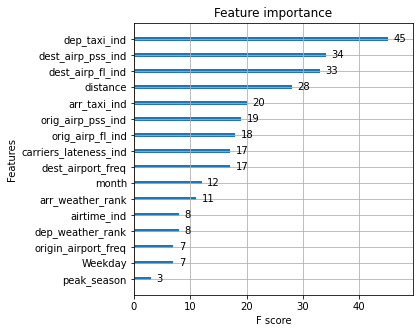

R2 Score  -0.045241909900972654
MAE:  13.524321107149124
RMSE:  19    46.021278
Name: test-rmse-mean, dtype: float64


In [392]:
XGBoost(df)

USING SKLEARN
Optimal number of features: 16
Selected Features =  Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16], dtype='int64')
Selected Features =  Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16], dtype='int64')


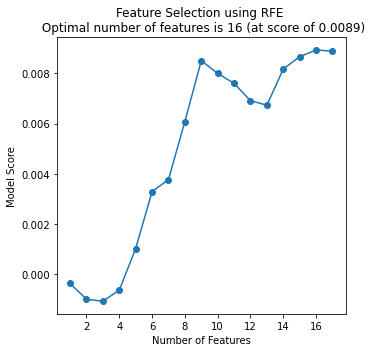

sklearn rscore on training data  0.015845504918971742
prediction of test:  [14.21497809 -2.39133055  6.65858532 ... 13.15091331 15.43456402
 15.49568381]
USING STATSMODELS
Optimal number of features: 16
Selected Features =  Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16], dtype='int64')
Selected Features =  Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16], dtype='int64')


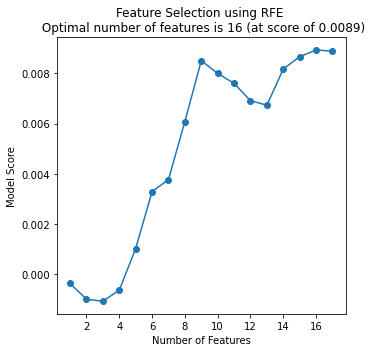

                            OLS Regression Results                            
Dep. Variable:            total_delay   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     7.027
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           2.18e-16
Time:                        11:38:44   Log-Likelihood:                -36875.
No. Observations:                7000   AIC:                         7.378e+04
Df Residuals:                    6983   BIC:                         7.390e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8976      0.562     22.949      0.0

In [375]:
linear_regression(df)
#random forest, KNN, XGBoost, They have regressors, make sure using regressors. 

In [345]:

with open("C:/Users/Peter/Documents/GitHub/Midterm_Project/Data/sklearn_model.pickle", "wb") as handle:
    pickle.dump(sklearn_score[0], handle)

In [376]:
with open('C:/Users/Peter/Documents/GitHub/Midterm_Project/Data/sklearn_model.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [377]:
test = df.drop('total_delay', axis=1)

In [380]:
x = model.predict(test)

In [ ]:
test = run_model(test, model)

In [ ]:
#pipeline is an sklearn module will help with debugging